<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_09_Nearest_Neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, Abilene Christian University, PHYS 453**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Common utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# Classifiers
from sklearn.neighbors import KNeighborsClassifier

# Tutorial 9 - Nearest Neighbors

We did a homebrew version of this in HW2, so now this tutorial walks through some basics using sklearn.neighbors.  

**References:**
* User Guide: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors
* API: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# Load Data
We'll graph everything in this tutorial, so we will only use 2 features from Iris

In [2]:
# Load only two features of Iris
data_bunch = datasets.load_iris()
data_bunch.keys()
X = data_bunch.data[:,:2] # Load just 2 features from the Iris Dataset
y = data_bunch.target

target_names = data_bunch.target_names
feature_names = data_bunch.feature_names
print('Targets:\t',target_names)
print('Feature:\t',feature_names)
print('Data shape:\t',X.shape)

Targets:	 ['setosa' 'versicolor' 'virginica']
Feature:	 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Data shape:	 (150, 2)


In [3]:
# Define custom colors for nice plots
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

Note: look at Tutorial 4 for a discussion about scatter plot legends

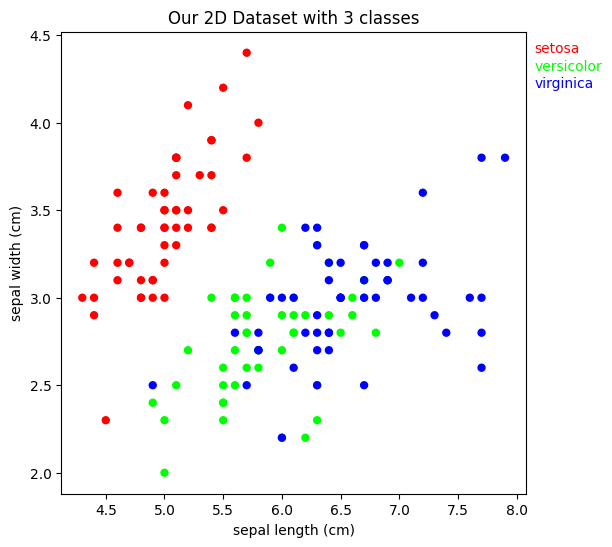

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,s=25, cmap=cmap_bold)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

# Make a homemade legend
legx = 8.15 # x position
legy = 4.4 # top y position
yoff = 0.1 # offset between entries
for i,color in enumerate(cmap_bold.colors):
  plt.text(legx,legy-i*yoff,target_names[i],color=color)

plt.title('Our 2D Dataset with 3 classes')
plt.show()

# Basic Usage
All sklearn classifiers follow the same methods like fit, predict, score, etc.

In [5]:
clf = KNeighborsClassifier()  #defaults to 5 neighbors
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [6]:
clf.fit(X,y)

KNeighborsClassifier()

# Decision Boundary
Visualize how KNN would classify new points by defining a grid over the feature space, predicting all of them, and making a plot.

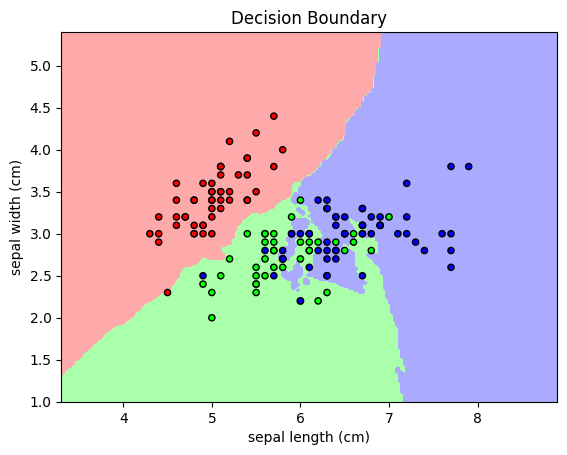

In [7]:
DecisionBoundaryDisplay.from_estimator(clf,X,grid_resolution=200,cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Decision Boundary')
plt.show()

# Measuring Distances
Now peek under the hood and see how classification works.  Make a new point and predict what it should be

In [8]:
Xnew = np.array([[4.6,2.6]])

In [9]:
clf.predict(Xnew)  # in this example, 0=red, 1=green, 2=blue

array([0])

Let's see why this point is classified as red.

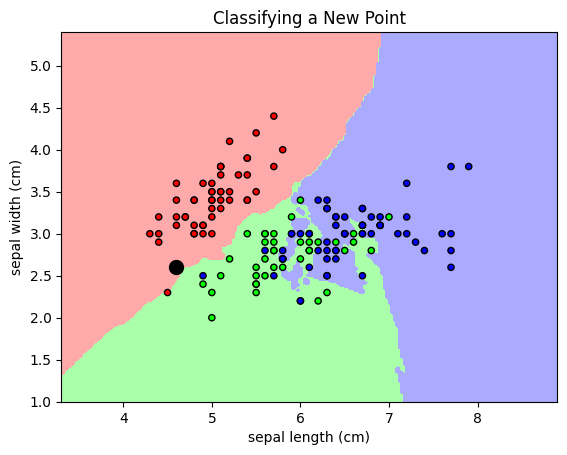

In [10]:
DecisionBoundaryDisplay.from_estimator(clf,X,grid_resolution=200,cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,edgecolor='k', s=20)
plt.scatter(Xnew[:,0], Xnew[:,1], color='black',s=100) # new point is large, black circle

plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Classifying a New Point')
plt.show()

The KNN class has fun methods for finding nearest neighbors.  See the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors

In [11]:
dist, ind = clf.kneighbors(Xnew,n_neighbors=5,return_distance=True)

In [12]:
np.set_printoptions(precision=3)
print(np.r_[dist,ind,y[ind]])

[[  0.316   0.316   0.361   0.361   0.447]
 [ 41.    106.      8.     57.     38.   ]
 [  0.      2.      0.      1.      0.   ]]


Above we display 5 columns for the requested 5 nearest neighbors.  First row is the distance, second is the index of the point, third is the class.  

We see that the 5 neighbors are 3 reds, 1 blue, and 1 green.

In [13]:
clf.predict_proba(Xnew)

array([[0.6, 0.2, 0.2]])

We found the 5 nearest neighbors.  There is a tie between the closest two (red and blue), but as we expand out our search we see that 3 of the 5 are reds.  So I predict 60% likely to be red, 20% prob each for green and blue

# Tuning Hyperparameters

Make some plots showing how k changes decision boundaries.  Pay attention to the outliers!

In general: **small K overfits, large k underfits**

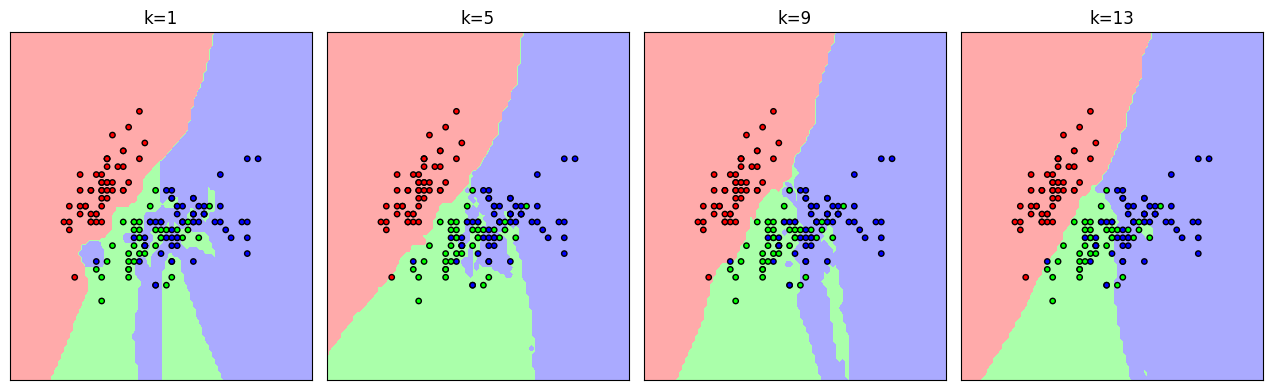

In [14]:
plt.figure(figsize=(16,4))
for i in range(4):
  k = 4*i+1;
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X,y)
  ax = plt.subplot(1,5,i+1)
  ax.set_xticks(())
  ax.set_yticks(())
  DecisionBoundaryDisplay.from_estimator(clf,X,grid_resolution=100,cmap=cmap_light,ax=ax)
  plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k',cmap=cmap_bold, s=15)
  ax.set_title('k=%i'%k)
plt.tight_layout()
plt.show()


Another common option is vote weights:
*   'uniform' - (default) votes from all neighbors count equally
*   'distance' - closer points get a bigger vote

Let's see what this does


In [15]:
for i in range(1,2):
  print(i)

1


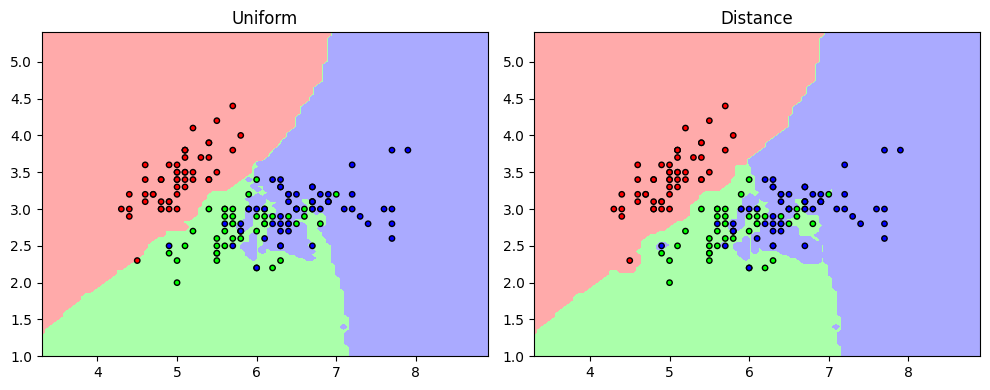

In [16]:
plt.figure(figsize=(10,4))
k=5
clf_uni = KNeighborsClassifier(n_neighbors=k,weights='uniform').fit(X,y)
clf_dist = KNeighborsClassifier(n_neighbors=k,weights='distance').fit(X,y)

# Whenever possible, use for loops instead of copying code
CLFS = [clf_uni, clf_dist]
TITLES = ['Uniform','Distance']

for i,(clf,title) in enumerate(zip(CLFS,TITLES)):
  ax = plt.subplot(1,2,i+1)
  DecisionBoundaryDisplay.from_estimator(clf,X,grid_resolution=100,cmap=cmap_light,ax=ax)
  plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k',cmap=cmap_bold, s=15)
  ax.set_title(title)

plt.tight_layout()
plt.show()

Notice how in distance weighting the outliers can still carve small islands in the decision boundary.  The bottom red point is a good example.

How do weights change our little classification exercise?

In [17]:
clf_uni.predict_proba(Xnew)

array([[0.6, 0.2, 0.2]])

In [18]:
clf_dist.predict_proba(Xnew)

array([[0.579, 0.197, 0.224]])

Distance weighting makes our little point more likely to be green

# Recipe Setup
Following Tutorial 8, here's a recipe for KNN to use.  I'll try to put all of the useful things together in one place

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0) # stratify ensures an equal ratio of each target

In [20]:
def plot_2par_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2,show_train=1):
  """Plot GridCV results for two parameter searches"""
  # from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv with a fixed bug
  val_scores = np.array(cv_results['mean_test_score']).reshape(len(grid_param_1),len(grid_param_2)) # FIXED A BUG HERE
  train_scores = np.array(cv_results['mean_train_score']).reshape(len(grid_param_1),len(grid_param_2))

  _, ax = plt.subplots(1,1,figsize=(10,4))
  cmap = plt.get_cmap("tab10")

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(grid_param_2):
    ax.plot(grid_param_1, val_scores[:,idx], '-o',  color=cmap(idx), label=f"Validation: {name_param_2}={str(val)}") # FIXED
    if show_train: ax.plot(grid_param_1, train_scores[:,idx], ':.', color=cmap(idx), label=f"Train: {name_param_2}={str(val)}")

  ax.set_title("Grid Search Scores")
  ax.set_xlabel(name_param_1)
  ax.set_ylabel('CV Average Score')
  ax.legend(loc='upper right')
  ax.grid('on')

# Recipe


**References**
* User Guide: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors
* API: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


**Parameters to know**
* ```n_neighbors```: also known as *k*, the number of neighbors. Default is 5
* ```weights```={‘uniform’, ‘distance’}: changes sensitivity to outliers, distance can work better but it is annoying that the validation score is always 1

**Training Notes**
* k=1 overfits while large values of k (close to N) underfits
* The training score is also always 1 for k=1 (unless there is a tie) or for distance weights
* Start with k=1 and increase to a large enough value that you see a peak in the validation scores
* You can try both options for ```weights``` or just use distance


Grid Parameters: {'clf__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'clf__weights': ['uniform', 'distance']}
Best parameters: {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}
Best Validation Score:	0.849


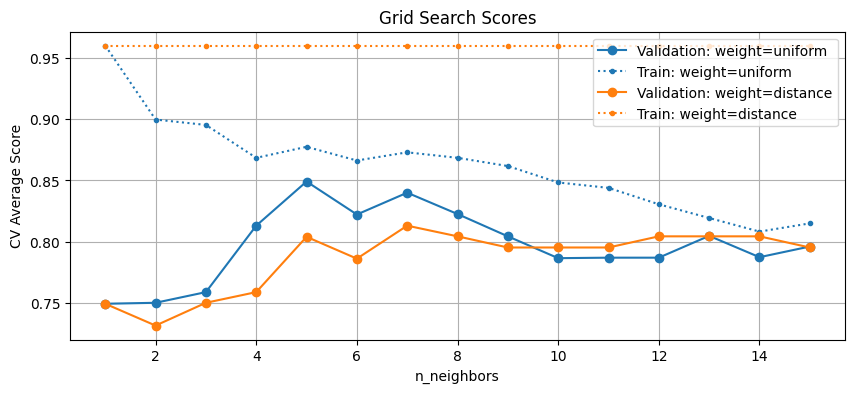

In [21]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,16)
WLIST = ['uniform','distance']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

plot_2par_grid_search(grid_clf.cv_results_, KLIST, WLIST, 'n_neighbors', 'weight')  # only works for 2 parameters
#make_grid_plot(grid_clf) # works for any number of parameters, but messier

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

If all is well, you should see a big gap between train and validation at small k where the model is overfitting.  As k increases they should meet and you should get a peak in validation scores.  

In general, you will usually see that *distance* outperforms *uniform* weights, but that isn't the case here.